In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_34686/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-07 12:26:59.336356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 12:26:59.371598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 12:26:

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
import tifffile as tiff
import glob
import re
import datetime

In [4]:
patch=99
imgs = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/*/*_patch_'+str(patch)+'.tif')
filenames=glob.glob('/cloud/s2_europa_test/ROIs1868/142/S2/*/*_patch_'+str(patch)+'.tif')


In [5]:

dates=[]
for file in filenames:
    tmp=re.search(r'\d{4}-\d{2}-\d{2}', file)
    dates.append(tmp[0])

sort_dates=sorted(dates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

#Get sorting indices
sort_ind_dates=[]
for date in sort_dates:
    sort_ind_dates.append(dates.index(date))

#Sort images according to date
imgs_sort=imgs[sort_ind_dates,:,:,:]

#Sort file names
filenames_sort=[]
for sort_ind in sort_ind_dates:
    filenames_sort.append(filenames[sort_ind]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


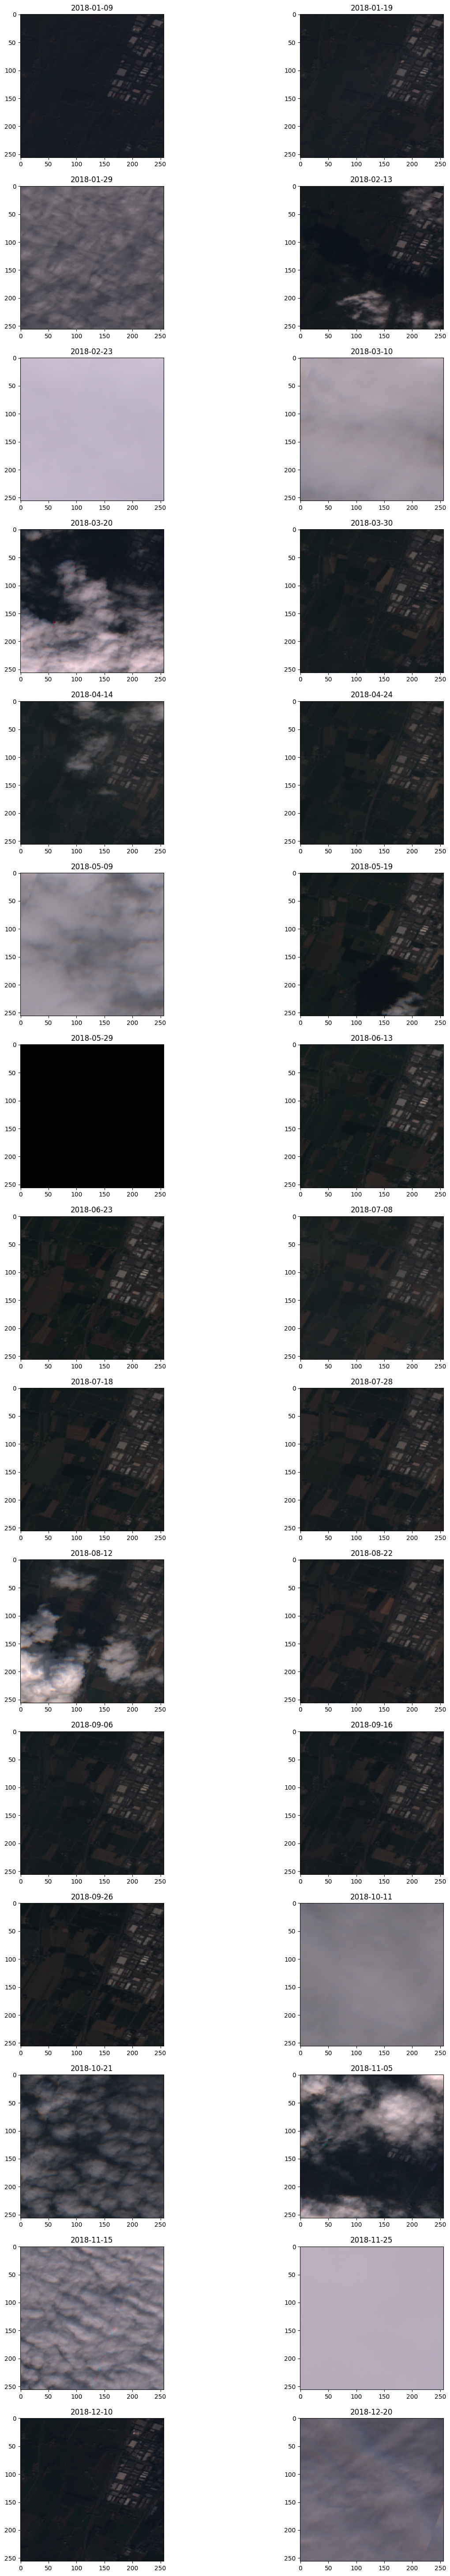

In [6]:
nrows=15
ncols=2
plt.rcParams["figure.figsize"] = [15, 5*nrows]
fig, axs =plt.subplots(nrows=nrows,ncols=ncols)
for i,ax in enumerate(axs.ravel()):
    im=imgs_sort[i,:,:,:]
    ax.imshow(im[:,:,[3,2,1]]/10000)
    ax.set_title(sort_dates[i])

In [7]:
filenames_sort

['/cloud/s2_europa_test/ROIs1868/142/S2/0/s2_ROIs1868_142_ImgNo_0_2018-01-09_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/1/s2_ROIs1868_142_ImgNo_1_2018-01-19_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/2/s2_ROIs1868_142_ImgNo_2_2018-01-29_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/3/s2_ROIs1868_142_ImgNo_3_2018-02-13_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/4/s2_ROIs1868_142_ImgNo_4_2018-02-23_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/5/s2_ROIs1868_142_ImgNo_5_2018-03-10_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/6/s2_ROIs1868_142_ImgNo_6_2018-03-20_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/7/s2_ROIs1868_142_ImgNo_7_2018-03-30_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/8/s2_ROIs1868_142_ImgNo_8_2018-04-14_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/9/s2_ROIs1868_142_ImgNo_9_2018-04-24_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/10/s2_ROIs1868_142_ImgNo_10_2018-05-09_p

In [8]:
img = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/8/s2_ROIs1868_142_ImgNo_8_2018-04-14_patch_99.tif')
img=img/10000


In [24]:
np.shape(img)

(256, 256, 13)

Text(0.5, 1.0, 'Example image with RGB channel (4,3,2)')

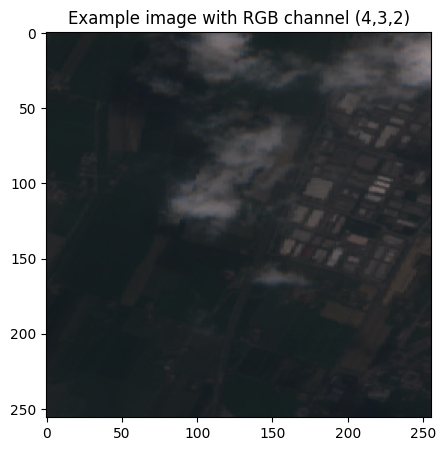

In [9]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(img[:,:,[3,2,1]])
plt.title("Example image with RGB channel (4,3,2)")

In [10]:
img_11=img[:,:,11]
img_11_flat=np.array([j for sub in img_11 for j in sub])

Text(0.5, 1.0, 'Example image with band 11')

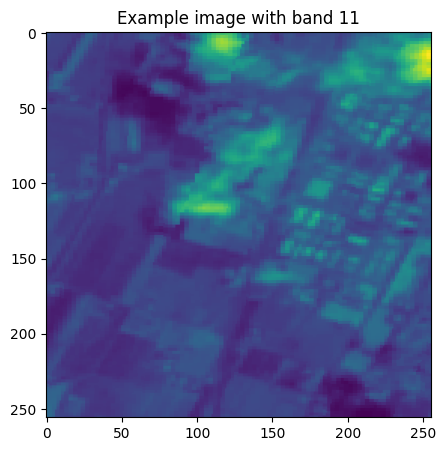

In [11]:
plt.imshow(img[:,:,11])
plt.title("Example image with band 11")

In [12]:
main_filepath='pytorch_models/model_7layers_100nodes_5ensemble'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)

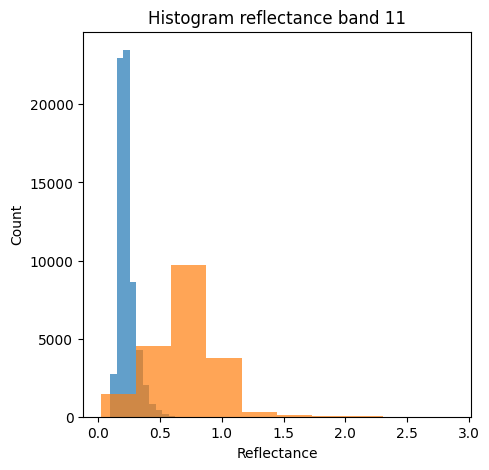

In [13]:

plt.hist(img_11_flat,alpha=0.7)
plt.hist(y_test.to_numpy()[:,11],alpha=0.7)
plt.title("Histogram reflectance band 11")
plt.xlabel("Reflectance")
plt.ylabel("Count")
plt.show()

In [14]:
#Reshape input image to correct form
img_12_bands=img[:,:,1:]
image_shape=np.shape(img_12_bands)
image_input=np.reshape(img_12_bands,(image_shape[0]*image_shape[1],image_shape[2]))

#Predict
for i,model in enumerate(models):
    if i==0:
        y_pred=model.predict(image_input)
    else:   
        y_pred=y_pred+model.predict(image_input)
y_pred=y_pred/len(models)

img_pred=y_pred[:,:,1] # Get median quantile

#Reshape output prediction
img_pred_reshape=np.reshape(img_pred,(image_shape[0],image_shape[1],image_shape[2]))


Text(0.5, 1.0, 'Example reconstruction band 11')

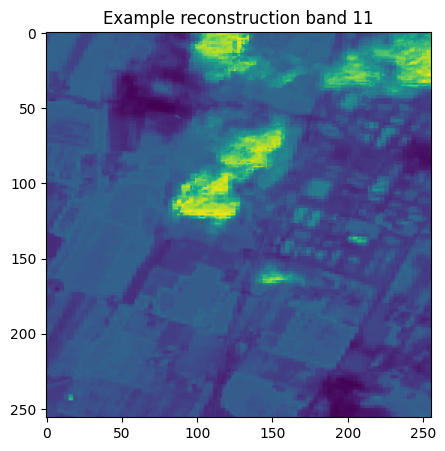

In [15]:
plt.imshow(img_pred_reshape[:,:,10])
plt.title("Example reconstruction band 11")

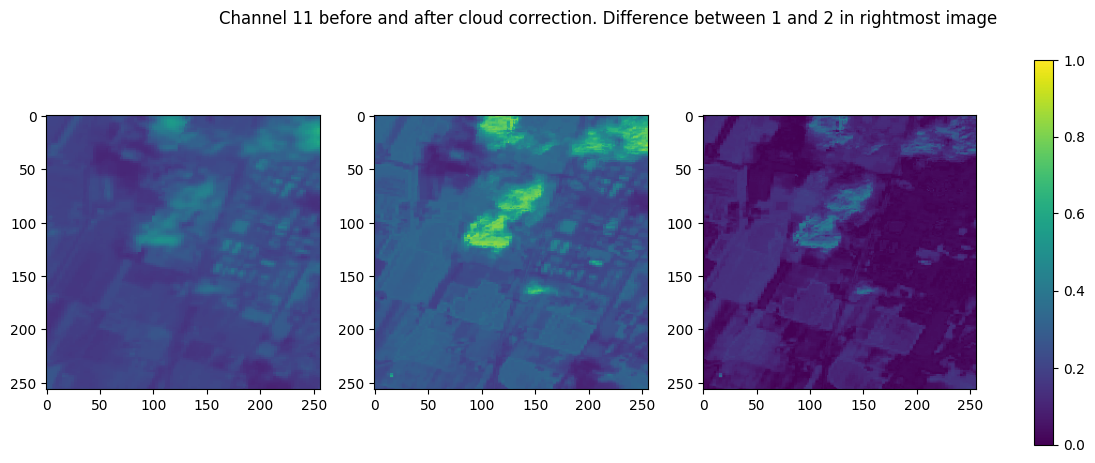

In [25]:
plt.rcParams["figure.figsize"] = [15, 5]
fig, axs =plt.subplots(nrows=1,ncols=3)
fig.suptitle("Channel 11 before and after cloud correction. Difference between 1 and 2 in rightmost image")

im1=axs[0].imshow(img[:,:,11],vmin=0,vmax=1)
im2=axs[1].imshow(img_pred_reshape[:,:,10],vmin=0,vmax=1)
im3=axs[2].imshow(np.abs((img[:,:,11])-(img_pred_reshape[:,:,10])),vmin=0,vmax=1)
fig.colorbar(im1,ax=axs.ravel().tolist())



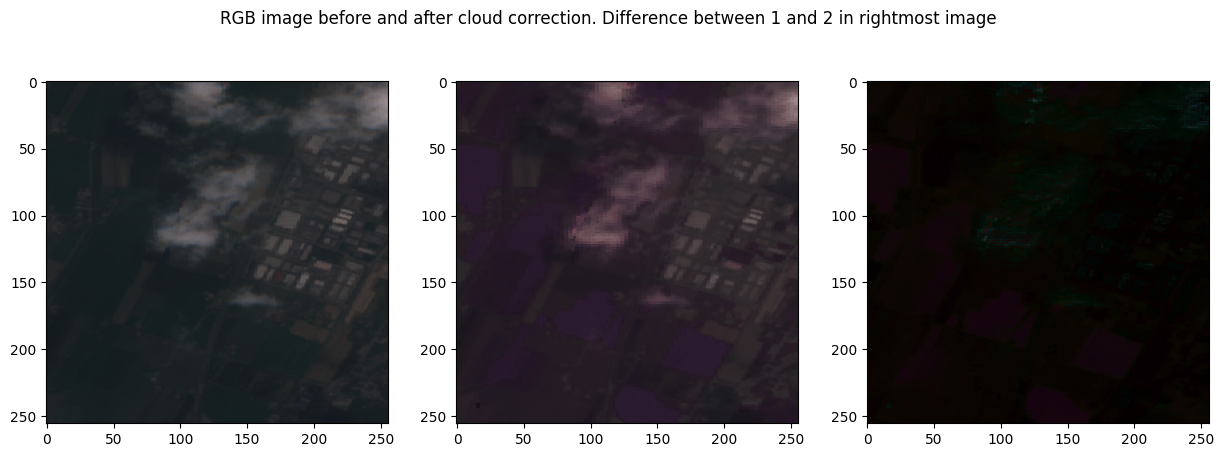

In [26]:
fig, axs =plt.subplots(nrows=1,ncols=3)
fig.suptitle("RGB image before and after cloud correction. Difference between 1 and 2 in rightmost image")

axs[0].imshow(img[:,:,[3,2,1]])
axs[1].imshow(img_pred_reshape[:,:,[2,1,0]])
axs[2].imshow(np.abs((img[:,:,[3,2,1]])-(img_pred_reshape[:,:,[2,1,0]])))

In [18]:
#Get quantiles of prediction

pred_quant_01=y_pred[:,:,0]
pred_quant_09=y_pred[:,:,2]

img_pred_01=np.reshape(pred_quant_01,(image_shape[0],image_shape[1],image_shape[2]))
img_pred_09=np.reshape(pred_quant_09,(image_shape[0],image_shape[1],image_shape[2]))

# Get uncertainty image
pred_uncertainty=img_pred_09-img_pred_01

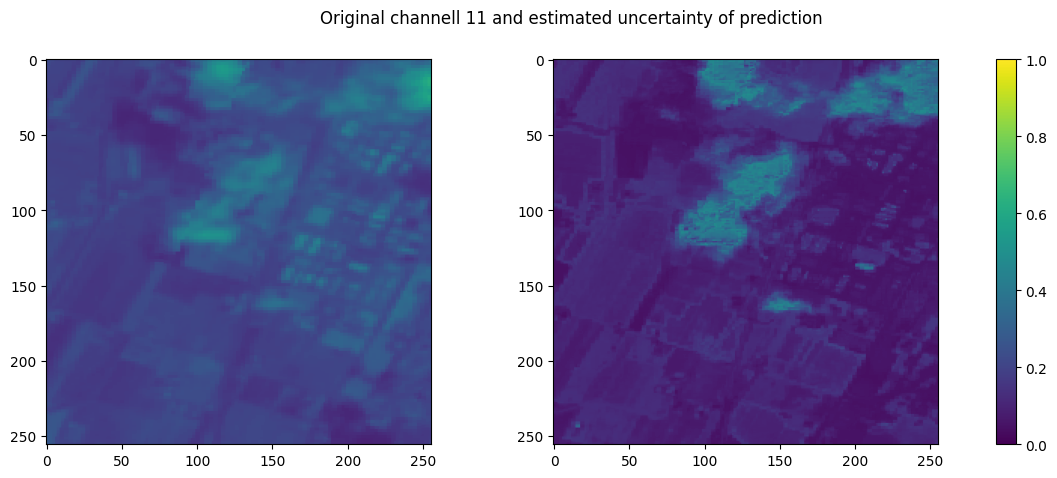

In [19]:
fig,axs=plt.subplots(nrows=1,ncols=2)
fig.suptitle("Original channell 11 and estimated uncertainty of prediction")
im1=axs[0].imshow(img[:,:,11],vmin=0,vmax=1)
axs[1].imshow(pred_uncertainty[:,:,10],vmin=0,vmax=1)
fig.colorbar(im1,ax=axs.ravel().tolist())